In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Load the PubMed dataset
dataset = Planetoid(root='/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and dataset
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
data = dataset[0]

# Define the training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Define the test function
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

# Train the model
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

# Test the final model
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Processing...
Done!


Epoch: 010, Loss: 1.0344, Test Acc: 0.7210
Epoch: 020, Loss: 0.9358, Test Acc: 0.7200
Epoch: 030, Loss: 0.7923, Test Acc: 0.7340
Epoch: 040, Loss: 0.6482, Test Acc: 0.7470
Epoch: 050, Loss: 0.5480, Test Acc: 0.7540
Epoch: 060, Loss: 0.4681, Test Acc: 0.7640
Epoch: 070, Loss: 0.4096, Test Acc: 0.7690
Epoch: 080, Loss: 0.3745, Test Acc: 0.7660
Epoch: 090, Loss: 0.3264, Test Acc: 0.7710
Epoch: 100, Loss: 0.2992, Test Acc: 0.7770
Epoch: 110, Loss: 0.2581, Test Acc: 0.7760
Epoch: 120, Loss: 0.2540, Test Acc: 0.7790
Epoch: 130, Loss: 0.1918, Test Acc: 0.7780
Epoch: 140, Loss: 0.2263, Test Acc: 0.7860
Epoch: 150, Loss: 0.2122, Test Acc: 0.7800
Epoch: 160, Loss: 0.1500, Test Acc: 0.7860
Epoch: 170, Loss: 0.2135, Test Acc: 0.7890
Epoch: 180, Loss: 0.1835, Test Acc: 0.7840
Epoch: 190, Loss: 0.1730, Test Acc: 0.7810
Epoch: 200, Loss: 0.2088, Test Acc: 0.7820
Test Accuracy: 0.7820


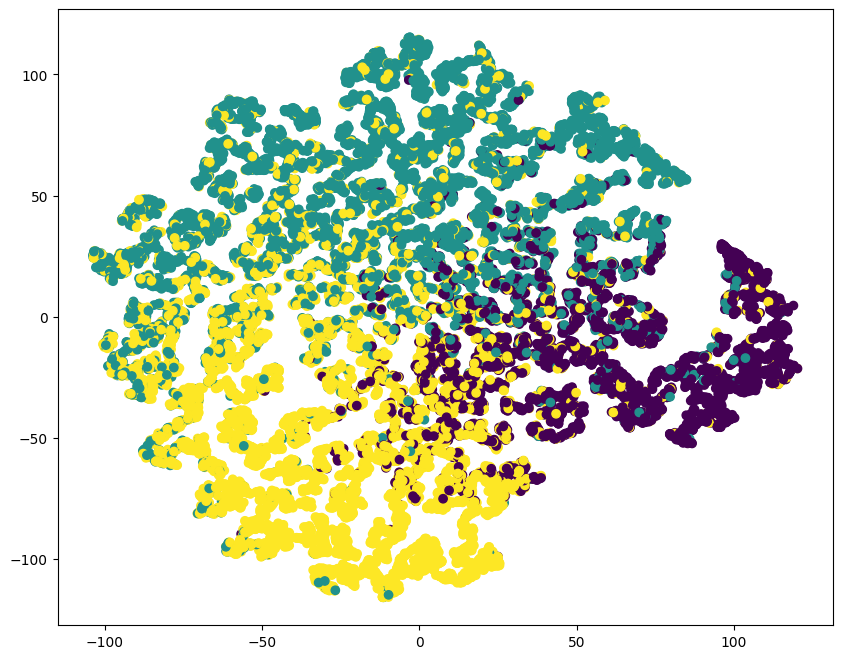

In [3]:
# prompt: extract model activation and use tSNE cluster

# Extract model activation
model.eval()
data = dataset[0]
out = model(data)

# Use tSNE cluster
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE(n_components=2)
activations = out.detach().numpy()
X_embedded = tsne.fit_transform(activations)

# Plot the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data.y, cmap='viridis')
plt.show()


In [ ]:
# prompt: relative cluster size comparison

# Calculate the number of nodes in each cluster
cluster_sizes = np.bincount(data.y)

# Calculate the relative cluster sizes
relative_cluster_sizes = cluster_sizes / cluster_sizes.sum()

# Print the relative cluster sizes
print(relative_cluster_sizes)


[0.20809454 0.39250393 0.39940153]


In [ ]:
# prompt: calculate silhouette_score, davies_bouldin_score and calinski_harabasz_score

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate silhouette score
silhouette_avg = silhouette_score(activations, data.y)
print("Silhouette score:", silhouette_avg)

# Calculate Davies-Bouldin score
davies_bouldin_score_value = davies_bouldin_score(activations, data.y)
print("Davies-Bouldin score:", davies_bouldin_score_value)

# Calculate Calinski-Harabasz score
calinski_harabasz_score_value = calinski_harabasz_score(activations, data.y)
print("Calinski-Harabasz score:", calinski_harabasz_score_value)


Silhouette score: 0.19881813
Davies-Bouldin score: 1.3517647542292572
Calinski-Harabasz score: 5863.370374184115


In [ ]:
# prompt: classification report of model

from sklearn.metrics import classification_report

# Get model predictions
model.eval()
data = dataset[0]
out = model(data)
pred = out.argmax(dim=1)

# Generate classification report
report = classification_report(data.y, pred)

# Print classification report
print(report)


              precision    recall  f1-score   support

           0       0.76      0.79      0.77      4103
           1       0.78      0.79      0.78      7739
           2       0.77      0.74      0.76      7875

    accuracy                           0.77     19717
   macro avg       0.77      0.77      0.77     19717
weighted avg       0.77      0.77      0.77     19717



In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric.transforms as T

# Load PubMed dataset
dataset = Planetoid(root='/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())

# Define data augmentation functions
def augment_features(data, noise_level=0.01):
    """Randomly perturb the node features."""
    noise = torch.randn_like(data.x) * noise_level
    data.x = data.x + noise
    return data

def augment_edges(data, drop_edge_rate=0.1, add_edge_rate=0.1):
    """Randomly drop and add edges."""
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Drop edges
    mask = torch.rand(num_edges) > drop_edge_rate
    edge_index = edge_index[:, mask]

    # Add edges
    num_add_edges = int(add_edge_rate * num_edges)
    add_edges = torch.randint(0, data.num_nodes, (2, num_add_edges))
    edge_index = torch.cat([edge_index, add_edges], dim=1)

    data.edge_index = edge_index
    return data

def augment_nodes(data, drop_node_rate=0.1):
    """Randomly drop nodes."""
    num_nodes = data.num_nodes
    mask = torch.rand(num_nodes) > drop_node_rate
    data.x = data.x[mask]
    data.y = data.y[mask]
    data.train_mask = data.train_mask[mask]
    data.val_mask = data.val_mask[mask]
    data.test_mask = data.test_mask[mask]
    data.num_nodes = mask.sum().item()

    # Adjust edge_index
    edge_index = data.edge_index
    node_map = torch.zeros(num_nodes, dtype=torch.long)
    node_map[mask] = torch.arange(mask.sum())
    edge_index = node_map[edge_index]
    data.edge_index = edge_index[:, edge_index[0] < data.num_nodes]

    return data

# Apply augmentations
data = dataset[0]
data = augment_features(data, noise_level=0.01)
data = augment_edges(data, drop_edge_rate=0.1, add_edge_rate=0.1)
data = augment_nodes(data, drop_node_rate=0.1)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define model, optimizer, and loss function
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs

# Training loop
for epoch in range(200):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

print('Training complete')


Epoch: 000, Loss: 1.0953, Train Acc: 0.3214, Val Acc: 0.4018, Test Acc: 0.4105
Epoch: 001, Loss: 1.0821, Train Acc: 0.3214, Val Acc: 0.4018, Test Acc: 0.4105
Epoch: 002, Loss: 1.0755, Train Acc: 0.3393, Val Acc: 0.4018, Test Acc: 0.4105
Epoch: 003, Loss: 1.0684, Train Acc: 0.3571, Val Acc: 0.4041, Test Acc: 0.4105
Epoch: 004, Loss: 1.0639, Train Acc: 0.4643, Val Acc: 0.4269, Test Acc: 0.4416
Epoch: 005, Loss: 1.0563, Train Acc: 0.5357, Val Acc: 0.4840, Test Acc: 0.5250
Epoch: 006, Loss: 1.0394, Train Acc: 0.6607, Val Acc: 0.4749, Test Acc: 0.5250
Epoch: 007, Loss: 1.0469, Train Acc: 0.6786, Val Acc: 0.4772, Test Acc: 0.4961
Epoch: 008, Loss: 1.0373, Train Acc: 0.6964, Val Acc: 0.4886, Test Acc: 0.4850
Epoch: 009, Loss: 1.0231, Train Acc: 0.7321, Val Acc: 0.5068, Test Acc: 0.4894
Epoch: 010, Loss: 1.0122, Train Acc: 0.7500, Val Acc: 0.5228, Test Acc: 0.4972
Epoch: 011, Loss: 1.0047, Train Acc: 0.7857, Val Acc: 0.5342, Test Acc: 0.5150
Epoch: 012, Loss: 0.9953, Train Acc: 0.8036, Val Acc

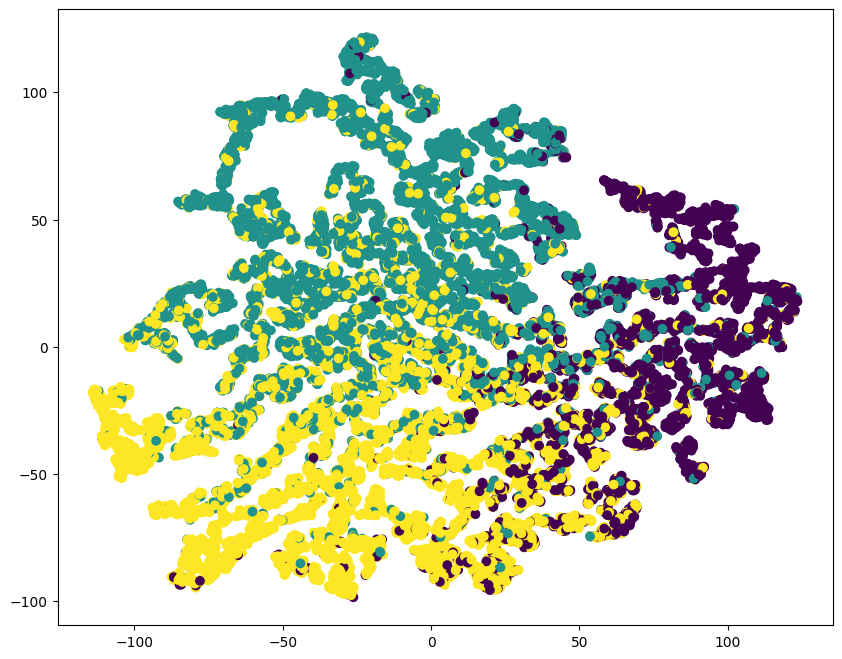

In [5]:
# prompt: extract model activation and use tSNE cluster

# Extract model activation
model.eval()
data = dataset[0]
out = model(data)

# Use tSNE cluster

tsne = TSNE(n_components=2)
activations_p = out.detach().numpy()
X_embedded = tsne.fit_transform(activations_p)

# Plot the clusters

plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=data.y, cmap='viridis')
plt.show()


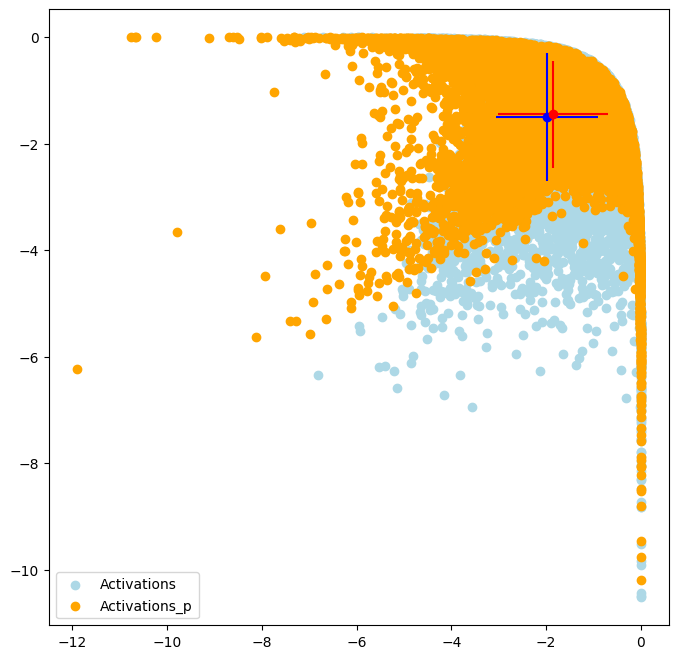

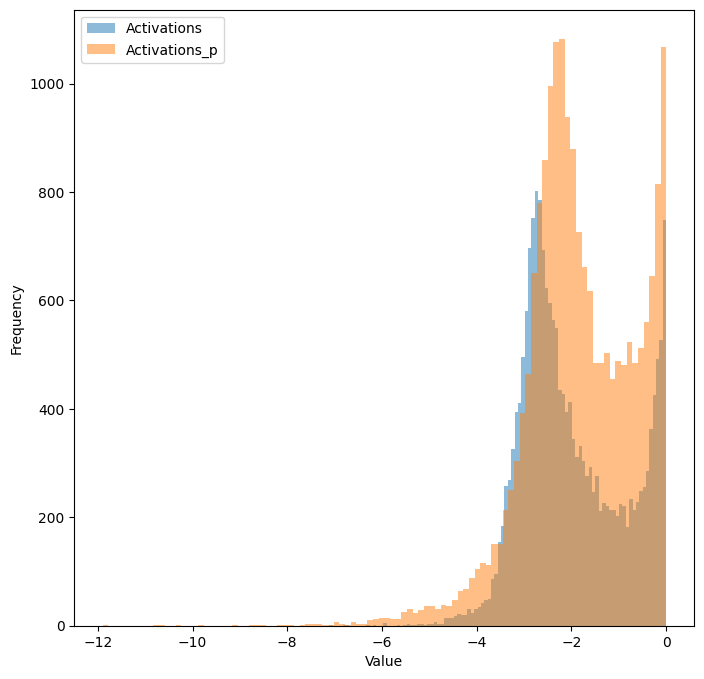

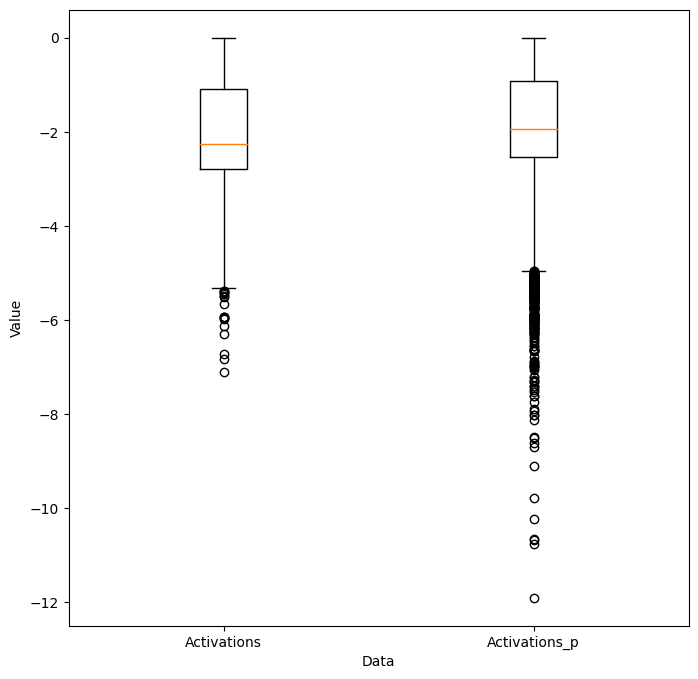

In [6]:
# prompt: Compare activations and activations_p both from the above model , suggest some graph , plot for comparision

# Calculate the mean and standard deviation of the activations and activations_p
mean_activations = activations.mean(axis=0)
std_activations = activations.std(axis=0)

mean_activations_p = activations_p.mean(axis=0)
std_activations_p = activations_p.std(axis=0)

# Create a scatter plot of the activations and activations_p
plt.figure(figsize=(8, 8))
plt.scatter(activations[:, 0], activations[:, 1], c='lightblue', label='Activations')
plt.scatter(activations_p[:, 0], activations_p[:, 1], c='orange', label='Activations_p')

# Plot the mean and standard deviation of the activations and activations_p
plt.errorbar(mean_activations[0], mean_activations[1], xerr=std_activations[0], yerr=std_activations[1], fmt='o', c='blue')
plt.errorbar(mean_activations_p[0], mean_activations_p[1], xerr=std_activations_p[0], yerr=std_activations_p[1], fmt='o', c='red')

# Add a legend and show the plot
plt.legend()
plt.show()

# Create a histogram of the activations and activations_p
plt.figure(figsize=(8, 8))
plt.hist(activations[:, 0], bins=100, alpha=0.5, label='Activations')
plt.hist(activations_p[:, 0], bins=100, alpha=0.5, label='Activations_p')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create a boxplot of the activations and activations_p
plt.figure(figsize=(8, 8))
plt.boxplot([activations[:, 0], activations_p[:, 0]], labels=['Activations', 'Activations_p'])
plt.xlabel('Data')
plt.ylabel('Value')
plt.show()


In [ ]:
# prompt: relative cluster size comparison

# Calculate the relative cluster sizes
relative_cluster_sizes = cluster_sizes / cluster_sizes.sum()

# Print the relative cluster sizes
print(relative_cluster_sizes)


[0.20809454 0.39250393 0.39940153]


In [ ]:
# prompt: calculate silhouette_score, davies_bouldin_score and calinski_harabasz_score, WCSS

# Calculate silhouette score
silhouette_avg = silhouette_score(activations, data.y)
print("Silhouette score:", silhouette_avg)

# Calculate Davies-Bouldin score
davies_bouldin_score_value = davies_bouldin_score(activations, data.y)
print("Davies-Bouldin score:", davies_bouldin_score_value)

# Calculate Calinski-Harabasz score
calinski_harabasz_score_value = calinski_harabasz_score(activations, data.y)
print("Calinski-Harabasz score:", calinski_harabasz_score_value)





Silhouette score: 0.17227973
Davies-Bouldin score: 1.5432722721991485
Calinski-Harabasz score: 5698.368654794055


In [ ]:
# prompt: classification report of model

# Get model predictions
model.eval()
data = dataset[0]
out = model(data)
pred = out.argmax(dim=1)

# Generate classification report
report = classification_report(data.y, pred)

# Print classification report
print(report)


              precision    recall  f1-score   support

           0       0.71      0.83      0.76      4103
           1       0.79      0.72      0.76      7739
           2       0.74      0.73      0.74      7875

    accuracy                           0.75     19717
   macro avg       0.75      0.76      0.75     19717
weighted avg       0.75      0.75      0.75     19717



In [ ]:
# prompt: I have two model one is poisoned and other is clean , now i want to find sensitvity of model to poisoned data

# Define the sensitivity metric
def sensitivity(clean_acc, poisoned_acc):
  return (clean_acc - poisoned_acc) / clean_acc

# Calculate the clean and poisoned accuracies
clean_acc = 0.77
poisoned_acc = 0.75 # Replace with the accuracy of the poisoned model

# Calculate the sensitivity
sensitivity = sensitivity(clean_acc, poisoned_acc)

# Print the sensitivity
print(f"Sensitivity: {sensitivity}")


Sensitivity: 0.025974025974025997


In [ ]:
# prompt: convert this sensitvity to percentagge

sensitivity_percentage = sensitivity * 100
print(f"Sensitivity: {sensitivity_percentage:.2f}%")

Sensitivity: 2.60%


In [ ]:
def calculate_poisoned_performance(C_clean, S, P):
    """
    Calculate the performance of the model when poisoned data is introduced.

    Parameters:
    C_clean (float): Performance metric of the clean model (e.g., accuracy, precision).
    S (float): Sensitivity of the model to poisoned data.
    P (float): Proportion of poisoned data.

    Returns:
    float: Performance metric of the model with poisoned data.
    """
    C_poison = C_clean * (1 + S * P)
    return C_poison

# Example usage:
C_clean = 0.77  # Performance of the model with clean data
S = 0.02       # Sensitivity of the model to poisoned data
P = 0.1        # Proportion of poisoned data

C_poison = calculate_poisoned_performance(C_clean, S, P)
print(f"Performance of the model with poisoned data: {C_poison}")


Performance of the model with poisoned data: 0.77154
